## Step 1: Import the libraries 📚

In [1]:
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import retro                 # Retro Environment


from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs
%matplotlib inline
from IPython import display

from collections import deque# Ordered collection with ends

import random

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore') 



## Step 2: Create our environment 🎮

In [2]:
# Create our environment
#env = retro.make(game='SpaceInvaders-Atari2600')
env = retro.make('StreetFighterIISpecialChampionEdition-Genesis', 
                 'rvsb.state', 
                 scenario='scenario',
                 players=1,
                 use_restricted_actions=retro.Actions.DISCRETE)

print("The size of our frame is: ", env.observation_space)
print("The action size is : ", env.action_space.n)
print(env.action_space.sample())

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]
# possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
possible_actions = np.array(list(range(1, 126+1)))


print(possible_actions)
print(len(possible_actions))

The size of our frame is:  Box(200, 256, 3)
The action size is :  126
44
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126]
126


## Step 3 : Define the preprocessing functions ⚙️
### preprocess_frame
Preprocessing is an important step, <b>because we want to reduce the complexity of our states to reduce the computation time needed for training.</b>
<br><br>
Our steps:
- Grayscale each of our frames (because <b> color does not add important information </b>).
- Crop the screen (in our case we remove the part below the player because it does not add any useful information)
- We normalize pixel values
- Finally we resize the preprocessed frame

In [3]:
"""
    preprocess_frame:
    Take a frame.
    Grayscale it
    Resize it.
        __________________
        |                 |
        |                 |
        |                 |
        |                 |
        |_________________|
        
        to
        _____________
        |            |
        |            |
        |            |
        |____________|
    Normalize it.
    
    return preprocessed_frame
    
    """
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

### stack_frames
As explained in this really <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  good article </a> we stack frames.

Stacking frames is really important because it helps us to **give have a sense of motion to our Neural Network.**

BUT, **we don't stack each frames, we skip 4 frames at each timestep**. This means that only every fourth frame is considered. And then, we use this frame to form the stack_frame.

**The frame skipping method is already implemented in the library.**

- First we preprocess frame
- Then we append the frame to the deque that automatically **removes the oldest frame**
- Finally we **build the stacked state**

This is how work stack:
- For the first frame, we feed 4 frames
- At each timestep, **we add the new frame to deque and then we stack them to form a new stacked frame**
- And so on
<img src="https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/master/DQN/Space%20Invaders/assets/stack_frames.png" alt="stack">
- If we're done, **we create a new stack with 4 new frames (because we are in a new episode)**.

In [4]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Step 4: Set up our hyperparameters ⚗️
In this part we'll set up our different hyperparameters. But when you implement a Neural Network by yourself you will **not implement hyperparamaters at once but progressively**.

- First, you begin by defining the neural networks hyperparameters when you implement the model.
- Then, you'll add the training hyperparameters when you implement the training algorithm.

In [5]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Step 5: Create our Deep Q-learning Neural Network model 🧠
<img src="https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/master/DQN/Space%20Invaders/assets/DQN%20Illustrations.png" alt="Model" />
This is our Deep Q-learning model:
- We take a stack of 4 frames as input
- It passes through 3 convnets
- Then it is flatened
- Finally it passes through 2 FC layers
- It outputs a Q value for each actions

In [6]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 126,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 126,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
            

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [7]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


## Step 6: Experience Replay 🔁
Now that we create our Neural Network, **we need to implement the Experience Replay method.** <br><br>
Here we'll create the Memory object that creates a deque.A deque (double ended queue) is a data type that **removes the oldest element each time that you add a new element.**

This part was taken from Udacity : <a href="https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb" Cartpole DQN</a>

In [8]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience (state, action, reward, next_state).

In [9]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
    choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    action = random.randint(1,126)
    next_state, reward, done, _ = env.step(action)
    
    #env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

## Step 7: Set up Tensorboard 📊
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=~/tensorboard/dqn/1`

In [10]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/Users/metsmania/tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Step 8: Train our Agent 🏃‍♂️

Our algorithm:
<br>
* Initialize the weights
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon) 
<br><br>
* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**

    

In [11]:
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

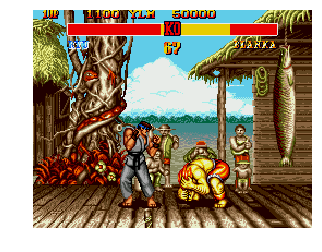

(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
(64, 110, 84, 4)
Episode: 0 Total reward: 1100.0 Explore P: 0.9899 Training Loss 1.1876
(64, 110, 84, 4)
Model Saved


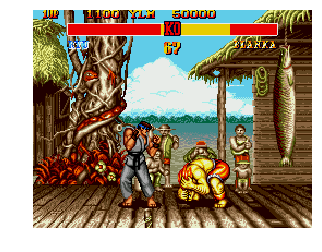

In [12]:
# Saver will help us to save our model
saver = tf.train.Saver()
training = True
total_episodes = 1
episode_render = True
if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            
            while step < max_steps:
                step += 1
                #print(step)
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                #print(action)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(action)
                
                if episode_render and step % 100 == 0 :
                    plt.imshow(env.render(mode='rgb_array'))
                    plt.axis('off')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    #rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                #actions_mb = np.array([each[1] for each in batch])
                list_agg = []
                for each in batch:
                    a_list = [0]*126
                    a_list[each[1]-1] = 1
                    list_agg.append(a_list)
                actions_mb = np.array(list_agg, ndmin=2)

                
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                print(next_states_mb.shape)
                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")

## Step 9: Test and Watch our Agent play 👀
Now that we trained our agent, we can test it

In [ ]:
plt.figure(3)
plt.clf()

env.close()
saver = tf.train.Saver()
env = retro.make('StreetFighterIISpecialChampionEdition-Genesis', 
                 'rvsb.state', 
                 scenario='scenario',
                 players=1,
                 use_restricted_actions=retro.Actions.DISCRETE)

with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    
    for episode in range(2):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            a_list = [0]*126
            a_list[choice] = 1
            print(action)
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
            plt.imshow(env.render(mode='rgb_array'))
            plt.axis('off')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            
    env.close()

In [ ]:
env.close()

In [ ]:
Qs

In [ ]:
Qs

In [17]:
for v in memory.buffer:
    print('%d, %d, %f, %d, %i' % (len(v[0]), v[1], v[2], len(v[3]), v[4]))
    print(v[0].shape)

110, 112, 0.000000, 110, 0
(110, 84, 4)
110, 7, 0.000000, 110, 0
(110, 84, 4)
110, 28, 0.000000, 110, 0
(110, 84, 4)
110, 9, 0.000000, 110, 0
(110, 84, 4)
110, 6, 0.000000, 110, 0
(110, 84, 4)
110, 107, 0.000000, 110, 0
(110, 84, 4)
110, 8, 0.000000, 110, 0
(110, 84, 4)
110, 92, 0.000000, 110, 0
(110, 84, 4)
110, 6, 0.000000, 110, 0
(110, 84, 4)
110, 94, 0.000000, 110, 0
(110, 84, 4)
110, 56, 0.000000, 110, 0
(110, 84, 4)
110, 38, 0.000000, 110, 0
(110, 84, 4)
110, 16, 0.000000, 110, 0
(110, 84, 4)
110, 53, 0.000000, 110, 0
(110, 84, 4)
110, 50, 0.000000, 110, 0
(110, 84, 4)
110, 84, 0.000000, 110, 0
(110, 84, 4)
110, 123, 0.000000, 110, 0
(110, 84, 4)
110, 119, 0.000000, 110, 0
(110, 84, 4)
110, 86, 0.000000, 110, 0
(110, 84, 4)
110, 30, 0.000000, 110, 0
(110, 84, 4)
110, 56, 0.000000, 110, 0
(110, 84, 4)
110, 48, 0.000000, 110, 0
(110, 84, 4)
110, 89, 0.000000, 110, 0
(110, 84, 4)
110, 12, 0.000000, 110, 0
(110, 84, 4)
110, 42, 0.000000, 110, 0
(110, 84, 4)
110, 88, 0.000000, 110, 0


110, 15, 0.000000, 110, 0
(110, 84, 4)
110, 114, 0.000000, 110, 0
(110, 84, 4)
110, 109, 0.000000, 110, 0
(110, 84, 4)
110, 124, 0.000000, 110, 0
(110, 84, 4)
110, 90, 0.000000, 110, 0
(110, 84, 4)
110, 87, 0.000000, 110, 0
(110, 84, 4)
110, 6, 0.000000, 110, 0
(110, 84, 4)
110, 93, 0.000000, 110, 0
(110, 84, 4)
110, 5, 0.000000, 110, 0
(110, 84, 4)
110, 21, 0.000000, 110, 0
(110, 84, 4)
110, 56, 0.000000, 110, 0
(110, 84, 4)
110, 48, 0.000000, 110, 0
(110, 84, 4)
110, 123, 0.000000, 110, 0
(110, 84, 4)
110, 123, 0.000000, 110, 0
(110, 84, 4)
110, 105, 0.000000, 110, 0
(110, 84, 4)
110, 22, 0.000000, 110, 0
(110, 84, 4)
110, 121, 0.000000, 110, 0
(110, 84, 4)
110, 114, 0.000000, 110, 0
(110, 84, 4)
110, 36, 0.000000, 110, 0
(110, 84, 4)
110, 6, 0.000000, 110, 0
(110, 84, 4)
110, 97, 0.000000, 110, 0
(110, 84, 4)
110, 50, 0.000000, 110, 0
(110, 84, 4)
110, 52, 0.000000, 110, 0
(110, 84, 4)
110, 125, 0.000000, 110, 0
(110, 84, 4)
110, 116, 0.000000, 110, 0
(110, 84, 4)
110, 29, 0.000000,

In [ ]:
# Saver will help us to save our model
saver = tf.train.Saver()
training = True
total_episodes = 1
episode_render = True
if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            
            while step < max_steps:
                step += 1
                #print(step)
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                #print(action)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(action)
                
                if episode_render and step % 100 == 0 :
                    plt.imshow(env.render(mode='rgb_array'))
                    plt.axis('off')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    #rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                #actions_mb = np.array([each[1] for each in batch])
                list_agg = []
                for each in batch:
                    a_list = [0]*126
                    a_list[each[1]-1] = 1
                    list_agg.append(a_list)
                actions_mb = np.array(list_agg, ndmin=2)

                
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")